# チュートリアル: WikipediaのHTMLページから歴代アメリカ大統領の出生地を抽出する
DeepL翻訳

## postgresql準備
すでにpostgresqlにデータベースpob_presidentsが存在する場合は、1行目のコメントを外してドロップし、再作成してください。

In [1]:
# ! dropdb --if-exists pob_presidents #Uncomment to remove databases created in previous runs
! createdb pob_presidents

## Introduction

Webページ、ビジネスレポート、製品仕様書、科学文献に見られるような、テキスト、構造・表形式、視覚表現の組み合わせによって情報が伝達される[**リッチフォーマット**データ](https://hazyresearch.github.io/snorkel/blog/fonduer.html)から、`Fonduer`を使って関係を抽出する過程を説明します。

このチュートリアルでは、`Fonduer`を使って、大統領と副大統領の出生地をwikipediaの記事から同定します。HTMLファイルはWikipediaのマークアップ言語Wikitextから[wtf_wikipedia](https://github.com/spencermountain/wtf_wikipedia)を経由して生成されています。

チュートリアルはいくつかのパートに分かれており、それぞれが[論文](https://arxiv.org/abs/1703.05028)で概説された`Fonduer`パイプラインのフェーズと、KBCプロセスをカバーしています。

1. KBCの初期化
2. 候補者生成とマルチモーダルフィーチャー化
3. 確率的関係性分類
4. エラー解析とインタラクティブKBC

さらに、ユーザがラベリング関数を繰り返し改善することで、関係抽出の品質を向上させる方法を紹介します。

## Ph1：KBCの初期化

`Fonduer` のパイプラインの最初のフェーズでは、`Fonduer` はユーザが指定した`schema`を用いて、出力される KB が格納されるリレーショナルデータベースを初期化します。さらに、`Fonduer`は入力された`corpus`を繰り返し処理し、各文書を統一的なデータモデルに変換します。このモデルはリッチフォーマットなデータの多様性とマルチモーダル性を捉えることができます。この統一的なデータモデルは、残りのフェーズで使われる中間表現として機能します。

この前処理されたデータは、データベースに保存されます。データベースへの接続文字列は `Meta` オブジェクトに渡され、並列実行のために`PostgreSQL`データベースを初期化します。

便宜上、データベースを呼び出すための変数と、`Fonduer`パイプラインをどのレベルの並列化で実行するかを定義するための変数をいくつか初期化します。

続行する前に、`PostgreSQL`がインストールされていることと、`pob_presidents`という名前の新しいデータベースが作成されていることを確認してください。


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import logging

PARALLEL = 4 # assuming a quad-core machine
ATTRIBUTE = "pob_presidents"
conn_string = 'postgresql://localhost:5432/' + ATTRIBUTE

### 1.1 入力文書の解析と統一データモデルへの変換
このオブジェクトはデータベースとの接続を自動的に管理し、中間結果を保存することができます。

In [3]:
from fonduer import Meta, init_logging

# Configure logging for Fonduer
init_logging(log_dir="logs")

session = Meta.init(conn_string).Session()

[2022-04-16 11:45:37,213][INFO] fonduer.meta:49 - Setting logging directory to: logs/2022-04-16_11-45-37
[2022-04-16 11:45:37,267][INFO] fonduer.meta:135 - Connecting user:None to fonduer-postgres:5432/pob_presidents
[2022-04-16 11:45:38,190][INFO] fonduer.meta:162 - Initializing the storage schema


次に、wikpediaの記事コーパスを読み込み、統一的なデータモデルに変換します。各記事はHTMLファイルで表現されます。このHTMLファイルを解析し、テキスト、構造、表形式のモダリティ情報を持つロバストな統一データモデルを作成します。各文書は互いに独立しているので、並行して解析することができることに注意してください。この機能については`PostgreSQL`に依存しています。

#### HTMLDocPreprocessorの設定
まず、ドキュメントが格納されるパスを設定し、指定したパスにあるドキュメントを読み込むための `HTMLDocPreprocessor` を定義します。`max_docs` にはパースするドキュメントの最大数を指定します。

**注意: 次のステップを実行する前に `download_data.sh` を実行しておく必要があります。

In [4]:
from fonduer.parser.preprocessors import HTMLDocPreprocessor
from fonduer.parser import Parser

docs_path = "data/presidents/"
doc_preprocessor = HTMLDocPreprocessor(docs_path)

#### パーサーの設定
次に、PDF文書用のコーパスパーサーである`Parser`を設定します。
前処理として[spaCy](https://spacy.io/)を用いて、文書を文とトークンに分割します。
また、各文書の統一データモデルに含めるモダリティ情報を指定することが可能です。
以下では、構造情報だけでなく、[spaCy]を用いてこれらの文の品詞タグや依存構文構造などのアノテーションを提供する言語情報も有効にしています。
なお、構文解析の完了を示す進捗バーが表示された後、すべてのオブジェクトがデータベースに挿入されるまで、さらに時間がかかることに注意してください。

In [5]:
corpus_parser = Parser(session, structural=True, lingual=True)
%time corpus_parser.apply(doc_preprocessor, parallelism=PARALLEL)

[2022-04-16 11:45:39,270][INFO] fonduer.utils.udf:67 - Running UDF...


  0%|          | 0/78 [00:00<?, ?it/s]

CPU times: user 18.3 s, sys: 1.15 s, total: 19.5 s
Wall time: 7min 6s


そして、簡単なデータベースクエリ（`Fonduer`が使っている[SQLAlchemy](http://www.sqlalchemy.org/)の構文で書かれています）を使って、いくつの文書や文が解析されたか、あるいはそれぞれの文書にいくつの文が含まれているかをチェックすることができます。

In [6]:
from fonduer.parser.models import Document, Sentence

print(f"Documents: {session.query(Document).count()}")
print(f"Sentences: {session.query(Sentence).count()}")

Documents: 78
Sentences: 98397


### 1.2 コーパスをテストとトレーニングに分割する
ドキュメントを80:10:10の割合でtrain:dev:testに分割することにします。
ここでは、チュートリアルの一貫性を逆手に取り、非ランダムな順序でこれを行い、分割をそれぞれ[0]:[1]:[2]の番号で参照することに注意してください。

In [7]:
docs = session.query(Document).order_by(Document.name).all()
ld = len(docs)

train_docs = set()
dev_docs = set()
test_docs = set()
splits = (0.7, 0.85)
data = [(doc.name, doc) for doc in docs]
data.sort(key=lambda x: x[0])
for i, (doc_name, doc) in enumerate(data):
    if i < splits[0] * ld:
        train_docs.add(doc)
    elif i < splits[1] * ld:
        dev_docs.add(doc)
    else:
        test_docs.add(doc)
from pprint import pprint

pprint([x.name for x in train_docs])

['Alben_W._Barkley',
 'George_M._Dallas',
 'George_W._Bush',
 'Bill_Clinton',
 'Henry_Wilson',
 'Aaron_Burr',
 'Lyndon_B._Johnson',
 'Martin_Van_Buren',
 'Abraham_Lincoln',
 'Harry_S._Truman',
 'Joe_Biden',
 'Levi_P._Morton',
 'Dan_Quayle',
 'Charles_W._Fairbanks',
 'Hubert_Humphrey',
 'Garret_Hobart',
 'Gerald_Ford',
 'John_Adams',
 'Adlai_Stevenson',
 'Elbridge_Gerry',
 'James_A._Garfield',
 'Calvin_Coolidge',
 'Charles_G._Dawes',
 'John_Nance_Garner',
 'Herbert_Hoover',
 'John_Quincy_Adams',
 'Benjamin_Harrison',
 'Dick_Cheney',
 'George_H._W._Bush',
 'Jimmy_Carter',
 'Chester_A._Arthur',
 'Dwight_D._Eisenhower',
 'Franklin_Pierce',
 'George_Washington',
 'John_F._Kennedy',
 'George_Clinton',
 'James_S._Sherman',
 'John_C._Calhoun',
 'Charles_Curtis',
 'John_Tyler',
 'John_C._Breckinridge',
 'Barack_Obama',
 'Andrew_Jackson',
 'Grover_Cleveland',
 'Al_Gore',
 'Andrew_Johnson',
 'James_Monroe',
 'Henry_A._Wallace',
 'James_Madison',
 'Franklin_D._Roosevelt',
 'Hannibal_Hamlin',
 'Dan

## Ph2：メンション抽出とマルチモーダル特徴量によるcandidate抽出

フェーズ1より統一的なデータモデルが与えられると、`Fonduer`はユーザーから提供された`matchers`と`throttlers`に基づく`candidate`を抽出します。
次に`Fonduer`は統一されたデータから得られるマルチモダリティな情報を活用して、各候補のマルチモーダルな特徴を提供します。

### 2.1 ミッションの抽出

まず、コーパスからメンションを抽出します。
メンションとは、`candidate`を構成するオブジェクトの種類です。
例えば、(副)大統領の名前とそれに対応する出生地のペアを抽出したい場合、名前が1つのメンションとなり、出生地がもう1つのメンションとなります。
これらのメンションを組み合わせて`candidate`を作成し、関連する文書においてどの`candidate`が正しいかを予測します。

まず、2つの`mention`の定義と命名を始めます。

In [8]:
from fonduer.candidates.models import mention_subclass

Presidentname = mention_subclass("Presidentname")
Placeofbirth = mention_subclass("Placeofbirth")

次に、コーパス中のどのテキストスパンが各エンティティのインスタンスであるかを定義するために、`matcher`を記述します。
`matcher`は正規表現、辞書、ユーザー定義関数など様々な情報を利用することができます。
異なる技術を組み合わせることで、より質の高い`matcher`を作成することができます。
一般に、`matcher`は完全な再現性を維持しながら、可能な限り正確であることを追求する必要があります。
`matcher`に関する詳しいドキュメントは、[Read the Docs](https://fonduer.readthedocs.io/en/stable/user/candidates.html#matchers)に掲載されています。

この例では、名前に対応する文字列を定義する`matcher`を記述する必要があります。
大統領を定義する`matcher`と、出生地を定義する`matcher`になります。

#### 名前のmatcher作成

名前の`matcher`は、htmlファイル名に大統領の名前が表示されていることを利用します。
大統領についてのメンションを見つけるために、「テキストの`span`をファイル名と比較する関数」を定義します。
すでに文書を統一的なデータモデルに変換したので、テキストの各`span`はソースの文書名を参照することができ、ソースファイル名との比較が容易です。

In [9]:
def mention_span_matches_file_name(mention):
    president_name_string = mention.get_span()
    file_name = mention.sentence.document.name.replace("_", " ")
    if president_name_string == file_name:
        return True
    else:
        return False

この関数を `LambdaFunctionMatcher` を使って、 `Fonduer` に言及する`matcher`にラップします。

In [10]:
from fonduer.candidates.matchers import LambdaFunctionMatcher, Intersect, Union

president_name_matcher = LambdaFunctionMatcher(func=mention_span_matches_file_name)

#### 出生地のmatcher作成

出生地も正規性表現による指定が可能ですが、ここでは文書内の位置に基づいてマッチングを行います。
htmlファイルを確認すると、各ファイルにはそれぞれの大統領に関する最も重要な情報が記載された表が記載されています。
通常、表には左の列にはラベル、右の列にはそれに対応する値が存在しています。
この表情報を取得するために、「`span`が表の中にあり、同じ行の隣接するセルに「出生地」のラベルがあるかどうか」をチェックする関数を定義します。
さらに、出生地は通常、細かい位置とそれに続くそれぞれの状態に分割されていることがわかります。
ここでは、より細かい情報を収集したいので、セル内のテキストの最初の `span` だけを抽出するように指定します。

In [11]:
from fonduer.utils.data_model_utils import get_row_ngrams


def is_in_birthplace_table_row(mention):
    if not mention.sentence.is_tabular():
        return False
    ngrams = get_row_ngrams(mention, lower=True)
    birth_place_words = set(["birth", "place"])
    if birth_place_words <= set(ngrams):
        return True
    else:
        return False


def birthplace_left_aligned_to_punctuation(mention):
    # Return false, if the cell containing the text candidate does not have any reference
    # to `sentence` objects
    for sentence in mention.sentence.cell.sentences:
        sentence_parts = sentence.text.split(",")
        for sentence_part in sentence_parts:
            if sentence_part.startswith(mention.get_span()):
                return True
    return False


# We only want one granularity of the birth place
def no_commas_in_birth_place(mention):
    if "," in mention.get_span():
        return False
    else:
        return True

出生地のプロパティを取得するためのすべての関数を定義した後、`Intersect matcher`を介してそれらを結合します。
この`matcher`は、3つの関数がすべて一致した場合にのみ`span`を選択します。

In [12]:
birth_place_in_labeled_row_matcher = LambdaFunctionMatcher(
    func=is_in_birthplace_table_row
)
birth_place_in_labeled_row_matcher.longest_match_only = False
birth_place_no_commas_matcher = LambdaFunctionMatcher(func=no_commas_in_birth_place)
birth_place_left_aligned_matcher = LambdaFunctionMatcher(
    func=birthplace_left_aligned_to_punctuation
)

place_of_birth_matcher = Intersect(
    birth_place_in_labeled_row_matcher,
    birth_place_no_commas_matcher,
    birth_place_left_aligned_matcher,
)

この2つの`matcher`は、関係スキーマの各エンティティを定義します。

#### メンション空間(MentionSpace)の定義

次に、ドキュメントから考えられるすべてのメンションの「空間」を定義するために、抽出したい関係の各要素に対して`MentionSpace`を定義していきます。
`Fonduer`はデフォルトの`MentionSpace`を用意していますが、必要に応じてデフォルトの`MentionSpace`を拡張することも可能です。

名前の場合、`MentionSpace`は比較的単純で、それぞれの名前には少なくとも2つの単語（名、姓）が含まれまています。
ミドルネームの追加を考慮すると、1つの名前に最大で4つの単語が含まれることが予想されます。

同様に、出生地は1語から3語の`span`であることが予想されます。

これらのプロパティを定義するために、`fonduer`が提供するデフォルトの`Ngrams`クラスを使用します。

In [13]:
from fonduer.candidates import MentionNgrams

presname_ngrams = MentionNgrams(n_max=4, n_min=2)
placeofbirth_ngrams = MentionNgrams(n_max=3)

#### メンション抽出の実行 

次に、上記で定義した`MentionSpace`と`matcher`を元に、全ての文書からメンションを抽出する`MentionExtractor`を作成します。

`MentionExtractor`のAPIは[ReadTheDocs](https://fonduer.readthedocs.io/en/stable/user/candidates.html#fonduer.candidates.MentionExtractor) で確認することができます。

In [14]:
from fonduer.candidates import MentionExtractor

mention_extractor = MentionExtractor(
    session,
    [Presidentname, Placeofbirth],
    [presname_ngrams, placeofbirth_ngrams],
    [president_name_matcher, place_of_birth_matcher],
)

すべての文書に対して`extractor`を実行します。

In [15]:
from fonduer.candidates.models import Mention

mention_extractor.apply(docs, parallelism=PARALLEL)
num_names = session.query(Presidentname).count()
num_pobs = session.query(Placeofbirth).count()
print(
    f"Total Mentions: {session.query(Mention).count()} ({num_names} names, {num_pobs} places of birth)"
)

[2022-04-16 11:52:46,246][INFO] fonduer.candidates.mentions:467 - Clearing table: presidentname
[2022-04-16 11:52:46,384][INFO] fonduer.candidates.mentions:467 - Clearing table: placeofbirth
[2022-04-16 11:52:46,389][INFO] fonduer.utils.udf:67 - Running UDF...


  0%|          | 0/78 [00:00<?, ?it/s]

Total Mentions: 1321 (1197 names, 124 places of birth)


### 2.2 candidateの抽出

`candidate`を構成するためのメンションの定義と抽出ができたので、次は`candidate`の抽出を行います。
メンションと同様に、まず各候補のスキーマを定義します。
この例では、上記で定義した`Presidentname`と`Placeofbirth`のメンションからなる候補を作成します。
この`candidate`を`PresidentnamePlaceofbirth`と名付けます。

In [16]:
from fonduer.candidates.models import candidate_subclass

PresidentnamePlaceofbirth = candidate_subclass(
    "PresidentnamePlaceofbirth", [Presidentname, Placeofbirth]
)

#### Throttlersの定義

次に、余分な`candidate`を減らし、無効な`candidate`を不必要に対象にしないためのThrottlersを定義します。
`Throttler`は、`matcher`のようにフィルターとして機能し、取りこぼしはしない程度のフィルタとして作成するべきです。

ここでは、同じ表中にある`candidate`を破棄する`Throttler`を作成します。
(ただし、現在この`Throttler`は使っていません。`wtf_wikipedia`の問題で、大統領名がテーブルに存在しないことがあるからです。)

そのため、`Throttler`はスキップしています。
他の例でも`Throttler`をスキップすることは多いです。

#### CandidateExtractorの実行

これで、`candidate`抽出に必要なコンポーネントはすべて揃いました。
各`candidate`を構成する`mentions`と、余分な候補を取り除くための`throttler`を定義しました。
ここでは`CandidateExtractor`を定義して、使用する`candidate`のサブクラスと対応する`throttler`を定義します。

`CandidateExtractor`のAPIは [ReadTheDocs](https://fonduer.readthedocs.io/en/stable/user/candidates.html#fonduer.candidates.CandidateExtractor)で確認することができます。

In [17]:
from fonduer.candidates import CandidateExtractor

candidate_extractor = CandidateExtractor(session, [PresidentnamePlaceofbirth])

ここでは、`split=0`を指定して、これらの`candidates`がトレーニングセットに属することを指定しています。
ここで、train:dev:testを[0]:[1]:[2]で分割して参照していることを思い出してください。

In [18]:
for i, docs in enumerate([train_docs, dev_docs, test_docs]):
    candidate_extractor.apply(docs, split=i, parallelism=PARALLEL)
    print(
        f"Number of Candidates in split={i}: {session.query(PresidentnamePlaceofbirth).filter(PresidentnamePlaceofbirth.split == i).count()}"
    )

train_cands = candidate_extractor.get_candidates(split=0)
dev_cands = candidate_extractor.get_candidates(split=1)
test_cands = candidate_extractor.get_candidates(split=2)

[2022-04-16 11:56:24,782][INFO] fonduer.candidates.candidates:138 - Clearing table presidentname_placeofbirth (split 0)
[2022-04-16 11:56:24,806][INFO] fonduer.utils.udf:67 - Running UDF...


  0%|          | 0/55 [00:00<?, ?it/s]

[2022-04-16 11:56:34,375][INFO] fonduer.candidates.candidates:138 - Clearing table presidentname_placeofbirth (split 1)
[2022-04-16 11:56:34,378][INFO] fonduer.utils.udf:67 - Running UDF...


Number of Candidates in split=0: 1561


  0%|          | 0/12 [00:00<?, ?it/s]

[2022-04-16 11:56:36,209][INFO] fonduer.candidates.candidates:138 - Clearing table presidentname_placeofbirth (split 2)
[2022-04-16 11:56:36,213][INFO] fonduer.utils.udf:67 - Running UDF...


Number of Candidates in split=1: 324


  0%|          | 0/11 [00:00<?, ?it/s]

Number of Candidates in split=2: 201


/home/user/.venv/lib/python3.7/site-packages/fonduer/candidates/candidates.py:201: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  .filter(candidate_class.id.in_(sub_query))


### 2.2 マルチモーダルな特徴づけ

構造化されていないテキストを扱うのとは異なり、`Fonduer`はリッチにフォーマットされたデータを扱うため、各`candidate`をマルチモーダル特徴の基本ライブラリで特徴量化します。

#### Postgres Featurizerによる特徴量化

次に、train:dev:test(学習セット、開発セット、テストセット)の`candidate`に特徴量のアノテーションを施します。
`Fonduer` が提供する`Featurizer`を使うと、この作業を並行して行うことができ、パフォーマンスを向上させることができます。

`Featurizer` が提供する API は [ReadTheDocs](https://fonduer.readthedocs.io/en/stable/user/features.html#fonduer.features.Featurizer) で確認することができます。

In [19]:
from fonduer.features import Featurizer

featurizer = Featurizer(session, [PresidentnamePlaceofbirth])
%time featurizer.apply(split=0, train=True, parallelism=PARALLEL)
%time F_train = featurizer.get_feature_matrices(train_cands)

/home/user/.venv/lib/python3.7/site-packages/fonduer/utils/utils_udf.py:217: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  .filter(candidate_class.id.in_(sub_query))
[2022-04-16 11:56:38,035][INFO] fonduer.features.featurizer:261 - Clearing Features (split 0)
/home/user/.venv/lib/python3.7/site-packages/fonduer/features/featurizer.py:271: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  query = self.session.query(Feature).filter(Feature.candidate_id.in_(sub_query))
[2022-04-16 11:56:38,047][INFO] fonduer.utils.udf:67 - Running UDF...


  0%|          | 0/55 [00:00<?, ?it/s]

CPU times: user 2.03 s, sys: 206 ms, total: 2.24 s
Wall time: 26.1 s
CPU times: user 20.3 s, sys: 376 ms, total: 20.6 s
Wall time: 21.8 s


In [20]:
print(F_train[0].shape)
%time featurizer.apply(split=1, parallelism=PARALLEL)
%time F_dev = featurizer.get_feature_matrices(dev_cands)
print(F_dev[0].shape)

[2022-04-16 11:57:25,982][INFO] fonduer.features.featurizer:261 - Clearing Features (split 1)
[2022-04-16 11:57:25,987][INFO] fonduer.utils.udf:67 - Running UDF...


(1561, 30318)


  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 297 ms, sys: 100 ms, total: 397 ms
Wall time: 5.01 s
CPU times: user 17.4 s, sys: 61.1 ms, total: 17.4 s
Wall time: 17.9 s
(324, 30318)


In [21]:
%time featurizer.apply(split=2, parallelism=PARALLEL)
%time F_test = featurizer.get_feature_matrices(test_cands)
print(F_test[0].shape)

[2022-04-16 11:57:48,902][INFO] fonduer.features.featurizer:261 - Clearing Features (split 2)
[2022-04-16 11:57:48,907][INFO] fonduer.utils.udf:67 - Running UDF...


  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 164 ms, sys: 114 ms, total: 278 ms
Wall time: 3.91 s
CPU times: user 15.8 s, sys: 42.3 ms, total: 15.9 s
Wall time: 16.2 s
(201, 30318)


このフェーズでは、`candidate`の集合と特徴行列を生成します。
なお、フェーズ1と2は比較的静的な処理であり、通常、KBCの処理中に一度だけ実行されるものです。

## Ph3: 確率的関係性分類
このフェーズでは、ユーザが定義した「ラベリング関数」を適用します。
このラベリング関数には、データにラベルを付けるための様々なヒューリスティックなパターン、および [weak supervision](http://hazyresearch.github.io/snorkel/blog/weak_supervision.html)が含まれており、各`candidate`に対して、データプログラミングエンジンが使用するラベル行列を作成します。

一般に、手作業でラベル付けされた学習データはまれであり、高価になります。
ここでは、大量のラベルなし学習データを対象に、それらをラベリング関数記述でラベル付けしていきます。
ラベル付けする知識の例として、「「New」「County」「City」といった単語が含まれると都市名である」といったような知識をラベリング関数として記述します。
ラベリング関数は完全ではなく、中には非常に低品質なものが記述される場合もあるため、生成モデルを用いてその精度をモデル化していくことになります。

そして、データプログラミングを用いて機械学習モデルを学習し、`candidate`を分類する際にどの特徴が最も重要であるかを学習することができます。

### ゴールドデータ(正解データ)の読み込み
エラー解析や評価を実施するため、このチュートリアルで使用するdevセットとtestセットには既にアノテーションを施してあります。
外部で定義されたヘルパー関数を使って読み込むことにします。

In [22]:
from fonduer.supervision.models import GoldLabel
from wiki_table_utils import gold

from fonduer.supervision import Labeler

docs = corpus_parser.get_documents()
labeler = Labeler(session, [PresidentnamePlaceofbirth])
%time labeler.apply(docs=docs, lfs=[[gold]], table=GoldLabel, train=True, parallelism=PARALLEL)

[2022-04-16 11:58:09,212][INFO] fonduer.supervision.labeler:330 - Clearing Labels (split ALL)
/home/user/.venv/lib/python3.7/site-packages/fonduer/supervision/labeler.py:340: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  query = self.session.query(table).filter(table.candidate_id.in_(sub_query))
[2022-04-16 11:58:09,223][INFO] fonduer.utils.udf:67 - Running UDF...


  0%|          | 0/78 [00:00<?, ?it/s]

CPU times: user 3.78 s, sys: 365 ms, total: 4.15 s
Wall time: 13.8 s


### ラベリング関数の作成

`Fonduer`では、学習する抽出モデルに学習シグナルを提供するための主要なインターフェースは、ラベリング関数(LF)を書くことです。
これは、大量の学習セットを手でラベリングするのとは対照的な作業です。

ラベリング関数は特別なものではありません。
`candidate`を入力引数として受け取り、`candidate`を「真/true」とすべきと判断した場合は「1」、「偽/False」とすべきと判断した場合は「0」、「棄権/Abstain」した場合は「-1」を返すPythonの関数に過ぎないのです。
実際には、多くのLFは単極性であり、TRUEかABSTAINを返すLF、FALSEかABSTAINを返すLFがほとんどです。
TRUEかFALSEを返すLF、もしくはTRUEかFALSEかABSTAINを返すLFは、別のLFとして分けた方がよいです。

ここでの目標は、最終的に`candidate`のうちどれが大統領名と出生地の関係を示すTRUEの`mention`であるかを予測する高性能な分類モデルを訓練することです。そのためには、低品質なラベリング関数を書けばわかりやすいです。

`Fonduer`を使えば、ラベリング関数を対象コーパスを調査して発見した直感的なパターンを使って書くことができます。
ラベリング関数を書くために使えるデータモデルユーティリティのライブラリは [Read the Docs](http://fonduer.readthedocs.io/en/stable/user/data_model_utils.html) に概要がまとめられています。

以下、このような単純なパターンのいくつかをラベリング関数の集合として表現していきます。

In [23]:
from snorkel.labeling import labeling_function
from fonduer.utils.data_model_utils import *
import re

ABSTAIN = -1
FALSE = 0
TRUE = 1


@labeling_function()
def LF_place_of_birth_has_link(c):
    place = c.placeofbirth
    ancestor_tag_names = get_ancestor_tag_names(place)
    if len(ancestor_tag_names) > 1 and "a" in ancestor_tag_names:
        return ABSTAIN
    else:
        return FALSE


@labeling_function()
def LF_place_of_birth_is_longest_ordered_span_before_comma(c):
    place = c.placeofbirth
    place_string = place.context.get_span()
    place_sentence_string = place.context.sentence.text
    left_aligned_first_span = place_sentence_string.split(",")[0]
    if place_string == left_aligned_first_span:
        return TRUE
    else:
        return FALSE


@labeling_function()
def LF_place_in_first_sentence_of_cell(c):
    place = c.placeofbirth
    place_sentence = place.context.sentence
    place_cell = place_sentence.cell
    if place_sentence == place_cell.sentences[0]:
        return TRUE
    else:
        return FALSE


@labeling_function()
def LF_place_is_full_sentence(c):
    place = c.placeofbirth
    place_sentence = place.context.sentence
    if place.context.get_span() == place_sentence.text:
        return ABSTAIN
    else:
        return FALSE


@labeling_function()
def LF_place_not_a_US_state(c):
    place = c.placeofbirth
    place_string = place.context.get_span().lower()
    if place_string is None:
        return FALSE
    state_dictionary = set(
        x.lower()
        for x in [
            "Alabama",
            "Alaska",
            "Arizona",
            "Arkansas",
            "California",
            "Colorado",
            "Connecticut",
            "Delaware",
            "Florida",
            "Georgia",
            "Hawaii",
            "Idaho",
            "Illinois",
            "Indiana",
            "Iowa",
            "Kansas",
            "Kentucky",
            "Louisiana",
            "Maine",
            "Maryland",
            "Massachusetts",
            "Michigan",
            "Minnesota",
            "Mississippi",
            "Missouri",
            "Montana",
            "Nebraska",
            "Nevada",
            "New Hampshire",
            "New Jersey",
            "New Mexico",
            "New York",
            "North Carolina",
            "North Dakota",
            "Ohio",
            "Oklahoma",
            "Oregon",
            "Pennsylvania",
            "Rhode Island",
            "South Carolina",
            "South Dakota",
            "Tennessee",
            "Texas",
            "Utah",
            "Vermont",
            "Virginia",
            "Washington",
            "West Virginia",
            "Wisconsin",
            "Wyoming",
        ]
    )
    if place_string == "new york city":  # exception
        return TRUE
    if place_string in state_dictionary:
        return FALSE
    elif any(x in place_string for x in state_dictionary):
        return FALSE
    else:
        return ABSTAIN

次に、使いたいラベリング関数を全て一つのリストに集め、それを `Labeler` の入力として提供していきます。

In [24]:
president_name_pob_lfs = [
    LF_place_of_birth_has_link,
    LF_place_of_birth_is_longest_ordered_span_before_comma,
    LF_place_not_a_US_state,
    LF_place_in_first_sentence_of_cell,
    LF_place_is_full_sentence,
]

### ラベリング関数の適用

すべての学習用`candidate`に対して実際にLFを実行し、`Labels`と`LabelKeys`のセット(LFの名前のみ)をデータベースに生成する必要があります。
このとき、既存の`Labels`と`LabelKeys`はすべて削除されることに注意してください。

[ReadTheDocs](https://fonduer.readthedocs.io/en/stable/user/supervision.html#fonduer.supervision.Labeler)で`Labeler`が提供するAPIを見ることができます。

In [25]:
%time labeler.apply(split=0, lfs=[president_name_pob_lfs], train=True, parallelism=PARALLEL)
%time L_train = labeler.get_label_matrices(train_cands)

/home/user/.venv/lib/python3.7/site-packages/fonduer/utils/utils_udf.py:217: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  .filter(candidate_class.id.in_(sub_query))
[2022-04-16 11:58:27,777][INFO] fonduer.supervision.labeler:330 - Clearing Labels (split 0)
/home/user/.venv/lib/python3.7/site-packages/fonduer/supervision/labeler.py:340: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  query = self.session.query(table).filter(table.candidate_id.in_(sub_query))
[2022-04-16 11:58:27,795][INFO] fonduer.utils.udf:67 - Running UDF...


  0%|          | 0/55 [00:00<?, ?it/s]

CPU times: user 1.05 s, sys: 255 ms, total: 1.31 s
Wall time: 4.19 s
CPU times: user 3.21 s, sys: 314 ms, total: 3.53 s
Wall time: 4.22 s


得られたラベルマトリックスに関する統計も見ることができます。
`Coverage`は、ラベリング関数が非ゼロのラベルを発行した`candidate`の割合です。
`Overlap`は、ラベリング関数が0以外のラベルを発行した`candidate`と、他のラベリング関数が0以外のラベルを発行した`candidate`の割合です。
`Conflict`は、ラベリング関数が非ゼロのラベルを発行し、別のラベリング関数が非ゼロのラベルと衝突する`candidate`の割合です。

また、すでにゴールドラベルを読み込んでいるので、[Snorkel](https://github.com/snorkel-team/snorkel)の`LFAnalysis`モジュールを使って、これらのラベリング関数とゴールドラベルを比較し、その経験的な精度を見ることができます。

In [26]:
L_gold_train = labeler.get_gold_labels(train_cands, annotator="gold")

In [27]:
from snorkel.labeling import LFAnalysis

LFAnalysis(
    L_train[0],
    lfs=sorted(president_name_pob_lfs, key=lambda lf: lf.name)
).lf_summary(Y=L_gold_train[0].reshape(-1))

/home/user/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/user/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/user/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/user/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing th

j Polarity  Coverage  \
LF_place_in_first_sentence_of_cell                  0   [0, 1]  1.000000   
LF_place_is_full_sentence                           1      [0]  0.538757   
LF_place_not_a_US_state                             2   [0, 1]  0.166560   
LF_place_of_birth_has_link                          3      [0]  0.115311   
LF_place_of_birth_is_longest_ordered_span_befor...  4   [0, 1]  1.000000   

                                                    Overlaps  Conflicts  \
LF_place_in_first_sentence_of_cell                  1.000000   0.803331   
LF_place_is_full_sentence                           0.538757   0.467008   
LF_place_not_a_US_state                             0.166560   0.124920   
LF_place_of_birth_has_link                          0.115311   0.070468   
LF_place_of_birth_is_longest_ordered_span_befor...  1.000000   0.803331   

                                                    Correct  Incorrect  \
LF_place_in_first_sentence_of_cell                     1428        133   
LF_place_is_full_sentence                               235        606   
LF_place_not_a_US_state                                 251          9   
LF_place_of_birth_has_link                              170         10   
LF_place_of_birth_is_longest_ordered_span_befor...      989        572   

                                                    Emp. Acc.  
LF_place_in_first_sentence_of_cell                   0.914798  
LF_place_is_full_sentence                            0.279429  
LF_place_not_a_US_state                              0.965385  
LF_place_of_birth_has_link                           0.944444  
LF_place_of_birth_is_longest_ordered_span_befor...   0.633568

### 生成モデルの適用

次に、LFのモデルを学習し、その精度を推定します。
モデルの学習が完了したら、LFの出力を組み合わせて、ノイズを考慮した単一の学習ラベルセットを作成し、抽出器に使用することができます。
直感的には、LFがどのように重なり合い、どのように衝突するかを観察することで、LFをモデル化することになります。
そのために、[Snorkel](https://github.com/snorkel-team/snorkel)のシングルタスクラベルモデルを利用します。

In [28]:
from snorkel.labeling.model import LabelModel

gen_model = LabelModel(cardinality=2)
%time gen_model.fit(L_train[0], n_epochs=500, log_freq=100)

[2022-04-16 11:58:40,195][INFO] root:903 - Computing O...
[2022-04-16 11:58:40,218][INFO] root:909 - Estimating \mu...
100%|██████████| 500/500 [00:00<00:00, 944.60epoch/s]
[2022-04-16 11:58:40,765][INFO] root:975 - Finished Training


CPU times: user 715 ms, sys: 142 ms, total: 857 ms
Wall time: 585 ms


ここで、学習`candidate`に生成モデルを適用し、ノイズを考慮した学習ラベルセットを取得します。
これを学習用マージナルと呼ぶことにします。

In [29]:
train_marginals = gen_model.predict_proba(L_train[0])

トレーニングマージンの分布を見てみます。

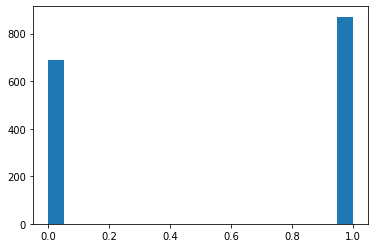

In [30]:
import matplotlib.pyplot as plt

plt.hist(train_marginals[:, TRUE], bins=20)
plt.show()

### ラベリング関数を反復するためのモデル使用

生成モデルの学習が終わったので、ここで一旦停止し、ラベリング関数セットのデバッグや改良を行うことができます。
まず、LFを開発セットに適用していきます。

In [31]:
labeler.apply(split=1, lfs=[president_name_pob_lfs], parallelism=PARALLEL)
%time L_dev = labeler.get_label_matrices(dev_cands)

/home/user/.venv/lib/python3.7/site-packages/fonduer/utils/utils_udf.py:217: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  .filter(candidate_class.id.in_(sub_query))
[2022-04-16 11:58:41,286][INFO] fonduer.supervision.labeler:330 - Clearing Labels (split 1)
/home/user/.venv/lib/python3.7/site-packages/fonduer/supervision/labeler.py:340: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  query = self.session.query(table).filter(table.candidate_id.in_(sub_query))
[2022-04-16 11:58:41,291][INFO] fonduer.utils.udf:67 - Running UDF...


  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 623 ms, sys: 113 ms, total: 736 ms
Wall time: 879 ms


In [32]:
L_dev[0].shape

(324, 5)

### 生成モデルの性能の解釈

この時点で、開発セットのF1スコアは約0.6～0.7となり、かなり良い値になっています。
しかし、この解釈には十分な注意が必要です。
この開発セットを参考にラベリング関数を開発し、そのラベリング関数で生成モデルを構成しているので、ここでは非常に良いスコアが期待できるのです。

実際には、この集合に対して多少過剰に適合していると思われます。
しかし、これは問題ありません。
次回は、開発セットを超えて汎化する、より強力な末端抽出モデルを学習し、ブラインドテストセット(開発中に一度も見ていないセット)で評価していきます。

### 識別モデルのトレーニング

最後に生成したノイズの多い学習ラベルを使って、抽出モデルを学習します。
このチュートリアルでは、シンプルでありながら、かなり効果的なロジスティック回帰モデルを学習します。

各`candidate`をtrueまたはfalseのメンションとして分類する識別モデルを訓練するために、訓練マージンを使用します。

Fonduerでは、新しい機械学習フレームワーク[Emmental](https://github.com/SenWu/emmental)を使用して、すべてのモデル学習をサポートします。

In [33]:
import emmental

# Setup training config
config = {
    "meta_config": {"verbose": True},
    "model_config": {"model_path": None, "device": 0, "dataparallel": False},
    "learner_config": {
        "n_epochs": 30,
        "optimizer_config": {"lr": 0.001, "l2": 0.0},
        "task_scheduler": "round_robin",
    },
    "logging_config": {
        "evaluation_freq": 1,
        "counter_unit": "epoch",
        "checkpointing": False,
        "checkpointer_config": {
            "checkpoint_metric": {f"{ATTRIBUTE}/{ATTRIBUTE}/train/loss": "min"},
            "checkpoint_freq": 1,
            "checkpoint_runway": 2,
            "clear_intermediate_checkpoints": True,
            "clear_all_checkpoints": True,
        },
    },
}

emmental.init(Meta.log_path)
emmental.Meta.update_config(config=config)

[2022-04-16 11:58:44,132][INFO] emmental.meta:122 - Setting logging directory to: logs/2022-04-16_11-45-37/2022_04_16/11_58_44/59e4336b
[2022-04-16 11:58:44,333][INFO] emmental.meta:64 - Loading Emmental default config from /home/user/.venv/lib/python3.7/site-packages/emmental/emmental-default-config.yaml.
[2022-04-16 11:58:44,335][INFO] emmental.utils.seed:30 - No random seed specified, randomly set random seed to 2593552972.
[2022-04-16 11:58:44,341][INFO] emmental.meta:174 - Updating Emmental config from user provided config.
[2022-04-16 11:58:44,343][INFO] emmental.utils.seed:30 - No random seed specified, randomly set random seed to 3458896838.


In [34]:
# Collect word counter from training data
from fonduer.learning.utils import collect_word_counter

word_counter = collect_word_counter(train_cands)

In [35]:
# Generate word embedding module for LSTM model
# (in Logistic Regression, we generate it since Fonduer dataset requires word2id dict)
from emmental.modules.embedding_module import EmbeddingModule

arity = 2

# Geneate special tokens
specials = []
for i in range(arity):
    specials += [f"~~[[{i}", f"{i}]]~~"]

emb_layer = EmbeddingModule(
    word_counter=word_counter, word_dim=300, specials=specials
)

In [36]:
# Generate dataloader for training set
from emmental.data import EmmentalDataLoader
from fonduer.learning.dataset import FonduerDataset
import numpy as np

# Filter out noise samples
diffs = train_marginals.max(axis=1) - train_marginals.min(axis=1)
train_idxs = np.where(diffs > 1e-6)[0]

train_dataloader = EmmentalDataLoader(
    task_to_label_dict={ATTRIBUTE: "labels"},
    dataset=FonduerDataset(
        ATTRIBUTE,
        train_cands[0],
        F_train[0],
        emb_layer.word2id,
        train_marginals,
        train_idxs,
    ),
    split="train",
    batch_size=100,
    shuffle=True,
)

In [37]:
# Creaet task and model, and perform training
from emmental.model import EmmentalModel
from fonduer.learning.task import create_task
from emmental.learner import EmmentalLearner

tasks = create_task(
    ATTRIBUTE, 2, F_train[0].shape[1], 2, emb_layer, model="LogisticRegression"
)

model = EmmentalModel(name=f"{ATTRIBUTE}_task")

for task in tasks:
    model.add_task(task)

emmental_learner = EmmentalLearner()
emmental_learner.learn(model, [train_dataloader])

[2022-04-16 11:58:56,782][INFO] fonduer.learning.task:92 - LogisticRegression model config: {'hidden_dim': 100, 'bias': False}
[2022-04-16 11:58:56,828][INFO] emmental.task:78 - Created task: pob_presidents
[2022-04-16 11:58:56,830][INFO] emmental.model:73 - Created emmental model pob_presidents_task that contains task set().
[2022-04-16 11:58:56,832][INFO] emmental.model:102 - No cuda device available. Switch shared_feature to cpu instead.
[2022-04-16 11:58:56,835][INFO] emmental.model:102 - No cuda device available. Switch pob_presidents_pred_head to cpu instead.
[2022-04-16 11:58:56,837][INFO] emmental.logging.logging_manager:43 - Evaluating every 1 epoch.
[2022-04-16 11:58:56,840][INFO] emmental.logging.logging_manager:64 - No checkpointing.
[2022-04-16 11:58:56,889][INFO] emmental.learner:123 - Using optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0.0
)
[2022-04-16 11:58:56,891][INFO] 

Epoch 1/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:58:58,327][INFO] emmental.learner:439 - Epoch: 1.00 {'pob_presidents/pob_presidents/train/loss': 0.3361330139740089, 'model/all/train/loss': 0.3361330139740089, 'model/all/train/lr': 0.001}


Epoch 2/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:58:59,740][INFO] emmental.learner:439 - Epoch: 2.00 {'pob_presidents/pob_presidents/train/loss': 0.11778499810818599, 'model/all/train/loss': 0.11778499810818599, 'model/all/train/lr': 0.001}


Epoch 3/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:01,106][INFO] emmental.learner:439 - Epoch: 3.00 {'pob_presidents/pob_presidents/train/loss': 0.06673067317968909, 'model/all/train/loss': 0.06673067317968909, 'model/all/train/lr': 0.001}


Epoch 4/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:02,560][INFO] emmental.learner:439 - Epoch: 4.00 {'pob_presidents/pob_presidents/train/loss': 0.0704179931453487, 'model/all/train/loss': 0.0704179931453487, 'model/all/train/lr': 0.001}


Epoch 5/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:03,911][INFO] emmental.learner:439 - Epoch: 5.00 {'pob_presidents/pob_presidents/train/loss': 0.05722832267126695, 'model/all/train/loss': 0.05722832267126695, 'model/all/train/lr': 0.001}


Epoch 6/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:05,238][INFO] emmental.learner:439 - Epoch: 6.00 {'pob_presidents/pob_presidents/train/loss': 0.05088347961683445, 'model/all/train/loss': 0.05088347961683445, 'model/all/train/lr': 0.001}


Epoch 7/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:06,574][INFO] emmental.learner:439 - Epoch: 7.00 {'pob_presidents/pob_presidents/train/loss': 0.05071047290892344, 'model/all/train/loss': 0.05071047290892344, 'model/all/train/lr': 0.001}


Epoch 8/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:07,910][INFO] emmental.learner:439 - Epoch: 8.00 {'pob_presidents/pob_presidents/train/loss': 0.047374780154396216, 'model/all/train/loss': 0.047374780154396216, 'model/all/train/lr': 0.001}


Epoch 9/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:09,330][INFO] emmental.learner:439 - Epoch: 9.00 {'pob_presidents/pob_presidents/train/loss': 0.044611226044199086, 'model/all/train/loss': 0.044611226044199086, 'model/all/train/lr': 0.001}


Epoch 10/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:10,753][INFO] emmental.learner:439 - Epoch: 10.00 {'pob_presidents/pob_presidents/train/loss': 0.0520733470296455, 'model/all/train/loss': 0.0520733470296455, 'model/all/train/lr': 0.001}


Epoch 11/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:12,092][INFO] emmental.learner:439 - Epoch: 11.00 {'pob_presidents/pob_presidents/train/loss': 0.05941182094423875, 'model/all/train/loss': 0.05941182094423875, 'model/all/train/lr': 0.001}


Epoch 12/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:13,457][INFO] emmental.learner:439 - Epoch: 12.00 {'pob_presidents/pob_presidents/train/loss': 0.04712926367301348, 'model/all/train/loss': 0.04712926367301348, 'model/all/train/lr': 0.001}


Epoch 13/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:14,793][INFO] emmental.learner:439 - Epoch: 13.00 {'pob_presidents/pob_presidents/train/loss': 0.04231707428085029, 'model/all/train/loss': 0.04231707428085029, 'model/all/train/lr': 0.001}


Epoch 14/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:16,152][INFO] emmental.learner:439 - Epoch: 14.00 {'pob_presidents/pob_presidents/train/loss': 0.043568299189544045, 'model/all/train/loss': 0.043568299189544045, 'model/all/train/lr': 0.001}


Epoch 15/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:17,612][INFO] emmental.learner:439 - Epoch: 15.00 {'pob_presidents/pob_presidents/train/loss': 0.04587965237763087, 'model/all/train/loss': 0.04587965237763087, 'model/all/train/lr': 0.001}


Epoch 16/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:18,939][INFO] emmental.learner:439 - Epoch: 16.00 {'pob_presidents/pob_presidents/train/loss': 0.0475332067896356, 'model/all/train/loss': 0.0475332067896356, 'model/all/train/lr': 0.001}


Epoch 17/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:20,314][INFO] emmental.learner:439 - Epoch: 17.00 {'pob_presidents/pob_presidents/train/loss': 0.05317358701495235, 'model/all/train/loss': 0.05317358701495235, 'model/all/train/lr': 0.001}


Epoch 18/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:21,683][INFO] emmental.learner:439 - Epoch: 18.00 {'pob_presidents/pob_presidents/train/loss': 0.04949761539086709, 'model/all/train/loss': 0.04949761539086709, 'model/all/train/lr': 0.001}


Epoch 19/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:23,034][INFO] emmental.learner:439 - Epoch: 19.00 {'pob_presidents/pob_presidents/train/loss': 0.04842396688568218, 'model/all/train/loss': 0.04842396688568218, 'model/all/train/lr': 0.001}


Epoch 20/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:24,535][INFO] emmental.learner:439 - Epoch: 20.00 {'pob_presidents/pob_presidents/train/loss': 0.04229440022180004, 'model/all/train/loss': 0.04229440022180004, 'model/all/train/lr': 0.001}


Epoch 21/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:25,955][INFO] emmental.learner:439 - Epoch: 21.00 {'pob_presidents/pob_presidents/train/loss': 0.04318691891529177, 'model/all/train/loss': 0.04318691891529177, 'model/all/train/lr': 0.001}


Epoch 22/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:27,314][INFO] emmental.learner:439 - Epoch: 22.00 {'pob_presidents/pob_presidents/train/loss': 0.03869928738661946, 'model/all/train/loss': 0.03869928738661946, 'model/all/train/lr': 0.001}


Epoch 23/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:28,731][INFO] emmental.learner:439 - Epoch: 23.00 {'pob_presidents/pob_presidents/train/loss': 0.0456756879154934, 'model/all/train/loss': 0.0456756879154934, 'model/all/train/lr': 0.001}


Epoch 24/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:30,176][INFO] emmental.learner:439 - Epoch: 24.00 {'pob_presidents/pob_presidents/train/loss': 0.05714116535226479, 'model/all/train/loss': 0.05714116535226479, 'model/all/train/lr': 0.001}


Epoch 25/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:31,676][INFO] emmental.learner:439 - Epoch: 25.00 {'pob_presidents/pob_presidents/train/loss': 0.04362009393622828, 'model/all/train/loss': 0.04362009393622828, 'model/all/train/lr': 0.001}


Epoch 26/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:33,069][INFO] emmental.learner:439 - Epoch: 26.00 {'pob_presidents/pob_presidents/train/loss': 0.04422682891483493, 'model/all/train/loss': 0.04422682891483493, 'model/all/train/lr': 0.001}


Epoch 27/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:34,570][INFO] emmental.learner:439 - Epoch: 27.00 {'pob_presidents/pob_presidents/train/loss': 0.04206874558414541, 'model/all/train/loss': 0.04206874558414541, 'model/all/train/lr': 0.001}


Epoch 28/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:36,708][INFO] emmental.learner:439 - Epoch: 28.00 {'pob_presidents/pob_presidents/train/loss': 0.04499913249486994, 'model/all/train/loss': 0.04499913249486994, 'model/all/train/lr': 0.001}


Epoch 29/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:38,278][INFO] emmental.learner:439 - Epoch: 29.00 {'pob_presidents/pob_presidents/train/loss': 0.04233980503393854, 'model/all/train/loss': 0.04233980503393854, 'model/all/train/lr': 0.001}


Epoch 30/30:   0%|          | 0/16 [00:00<?, ?it/s]

[2022-04-16 11:59:40,168][INFO] emmental.learner:439 - Epoch: 30.00 {'pob_presidents/pob_presidents/train/loss': 0.04133761709127611, 'model/all/train/loss': 0.04133761709127611, 'model/all/train/lr': 0.001}
[2022-04-16 11:59:40,218][INFO] emmental.learner:802 - Total learning time: 43.38032937049866 seconds.


## テストセットでの評価
この最後のセクションでは、ブラインドテストセットにおける抽出モデルのパフォーマンスを得ます(split 2)。
まず、先ほどのテストセットのラベルとゴールド`candidate`を読み込みます。

In [38]:
import numpy as np
from wiki_table_utils import entity_level_f1

今度は、判別モデルを使ったスコアリングを行います。

In [39]:
# Generate dataloader for test data
test_dataloader = EmmentalDataLoader(
    task_to_label_dict={ATTRIBUTE: "labels"},
    dataset=FonduerDataset(
        ATTRIBUTE, test_cands[0], F_test[0], emb_layer.word2id, 2
    ),
    split="test",
    batch_size=100,
    shuffle=False,
)

In [40]:
gold_file = "data/president_tutorial_gold.csv"

test_preds = model.predict(test_dataloader, return_preds=True)
positive = np.where(np.array(test_preds["probs"][ATTRIBUTE])[:, TRUE] > 0.6)
true_pred = [test_cands[0][_] for _ in positive[0]]
%time (TP, FP, FN) = entity_level_f1(true_pred, gold_file, test_docs)

Evaluating pob_presidents (test):   0%|          | 0/3 [00:00<?, ?it/s]

Preparing candidates...


/home/user/.venv/lib/python3.7/site-packages/fonduer/learning/task.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(intermediate_output_dict[module_name][0])


  0%|          | 0/161 [00:00<?, ?it/s]

Scoring on Entity-Level Gold Data
Corpus Precision 1.0
Corpus Recall    1.0
Corpus F1        1.0
----------------------------------------
TP: 11 | FP: 0 | FN: 0

CPU times: user 98.4 ms, sys: 485 µs, total: 98.9 ms
Wall time: 100 ms
